# Denoising Autoencoders

In [0]:
import sys
sys.path.append("..")

In [0]:
import tensorflow as tf
import tensorflow.keras,  tensorflow.keras.layers as L, tensorflow.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import numpy as np

In [0]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

X = X.astype('float32') / 255.0 - 0.5

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [0]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1389

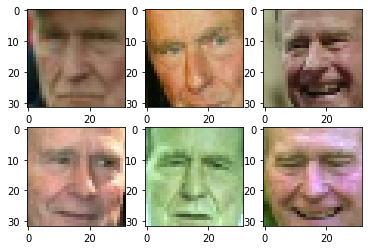

In [0]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [0]:
def build_pca_autoencoder(img_shape, code_size):
    """
    simple linear autoencoder.
    """
    
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  
    encoder.add(L.Dense(code_size))           

    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape))) 
    decoder.add(L.Reshape(img_shape))       
    
    return encoder,decoder

Meld them together into one model:

In [0]:
encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                verbose=0)

In [0]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.006494057364761829


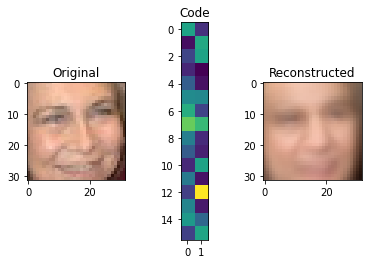

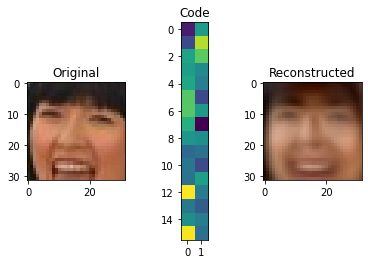

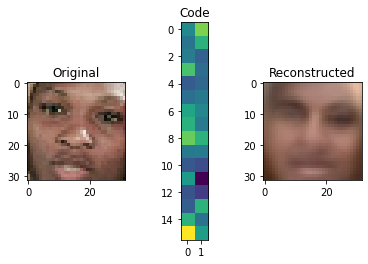

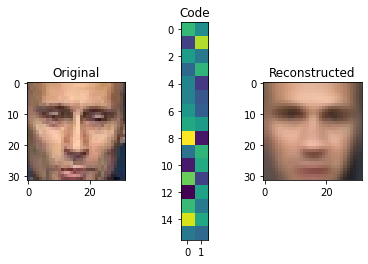

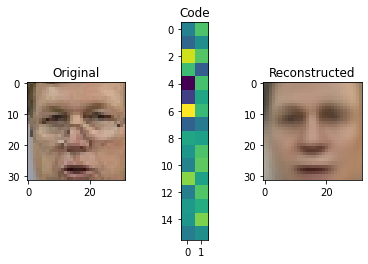

In [0]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    result =conv 
    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(result[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

In [0]:
clean = [[ 1,  2,  3,  4],
 [ 5,  6,  7,  8],
 [ 9, 10, 11, 12],
 [13, 14, 15, 16]]
clean1 = np.divide(clean, 50)
plt.imshow(clean1, cmap="Greys")
plt.show()

new = [[ 1,  1,  3,  2,  5,  3,  7,  4],
 [ 1,  1,  3,  2,  5,  3,  7,  4],
 [ 6,  6, 14,  8, 18, 10, 22, 12],
 [ 5,  5, 11,  6, 13,  7, 15,  8],
 [14, 14, 30, 16, 34, 18, 38, 20],
 [ 9,  9, 19, 10, 21, 11, 23, 12],
 [22, 22, 46, 24, 50, 26, 54, 28],
 [13, 13, 27, 14, 29, 15, 31, 16]]
new = np.divide(new,50)
plt.imshow(new, cmap="Greys")
plt.show()

In [0]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother"""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'elu'))
    encoder.add(L.MaxPooling2D())
    encoder.add(L.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'elu'))
    encoder.add(L.MaxPooling2D())
    encoder.add(L.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'elu'))
    encoder.add(L.MaxPooling2D())
    encoder.add(L.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'elu'))
    encoder.add(L.MaxPooling2D())
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    
    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(2 * 2 * 256))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'elu'))
    decoder.add(L.Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'elu'))
    decoder.add(L.Conv2DTranspose(filters = 32, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'elu'))
    decoder.add(L.Conv2DTranspose(filters = 3, kernel_size =  (3, 3), strides = 2, padding = 'same', activation = None))
    
    return encoder, decoder

In [0]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)       

Convolutional autoencoder training. Took **1 hour**.

In [0]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [0]:
#  model checkpoints
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### to continue training from model checkpoint
# from tensorflow.keras.models import load_model
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [0]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

  def on_train_batch_end(self, batch, logs=None):
    if batch%100==0:
      print('For batch {}, loss is {:7.5f}.'.format(batch, logs['loss']))

  def on_test_batch_end(self, batch, logs=None):
    if batch%100==0:
      print('For batch {}, loss is {:7.5f}.'.format(batch, logs['loss']))

  def on_epoch_end(self, epoch, logs=None):
    print('\t\t\t The average loss for epoch {} is {:7.5f}.'.format(epoch, logs['loss']))


In [0]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[LossAndErrorPrintingCallback()],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)

Convolutional autoencoder MSE: 0.006075057201087475


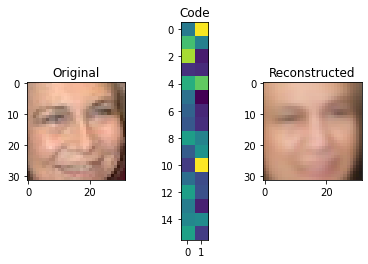

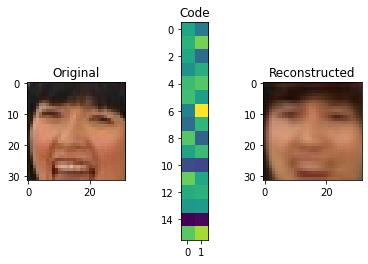

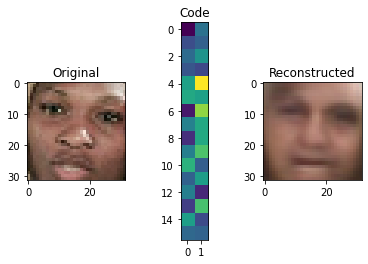

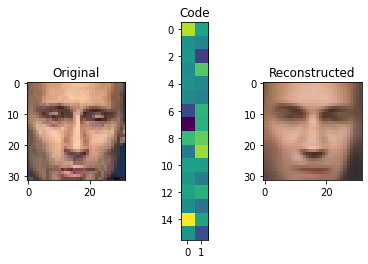

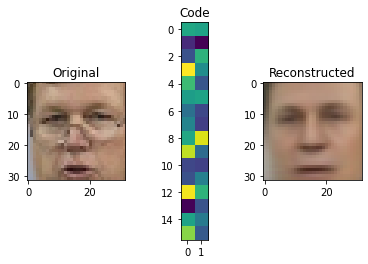

In [0]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [0]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.006075057201087475
0.006075057201087475
